In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
import torch
import torch.multiprocessing
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [2]:
GLOBAL_SEED = 42  # number of life
torch.manual_seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
torch.multiprocessing.set_sharing_strategy('file_system')

In [3]:
#load users data
users_title = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
#load movies data
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python', encoding='ISO-8859-1')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#load ratings data
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings["Rating"] = ratings["Rating"] - 3  # rating range (-2, 2)
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,2,978300760
1,1,661,0,978302109
2,1,914,0,978301968
3,1,3408,1,978300275
4,1,2355,2,978824291


In [6]:
#split train-test set
train_ratings, validation_ratings = train_test_split(
    ratings, test_size=0.1, random_state=42
)

In [7]:
# user_featuers
user_index_by_id = {id: idx for idx, id in enumerate(users["UserID"]) }
gender_index_by_name = {"M":0, "F": 1}
age_index_by_name = {1: 0, 18: 1, 25: 2, 35:3, 45: 4, 50: 5, 56:6}
occupations = [
    "other",
    "academic/educator",
    "artist",
    "clerical/admin",
    "college/grad student",
    "customer service",
    "doctor/health care",
    "executive/managerial",
    "farmer",
    "homemaker",
    "K-12 student",
    "lawyer",
    "programmer",
    "retired",
    "sales/marketing",
    "scientist",
    "self-employed",
    "technician/engineer",
    "tradesman/craftsman",
    "unemployed",
    "writer",
]
occupation_index_by_name = {name: index for index, name in enumerate(occupations)}

num_users = len(users)
gender_offset = num_users
age_offset = gender_offset + len(gender_index_by_name)
occupation_offset = age_offset + len(age_index_by_name)

user_features = []
for index in range(num_users):
    gender_index = gender_index_by_name[users["Gender"][index]] + gender_offset
    age_index = age_index_by_name[users["Age"][index]] + age_offset
    occupation_index = users["Occupation"][index] + occupation_offset
    user_features.append([index, gender_index, age_index, occupation_index])
    
print("Example for the first user: ", user_features[0])

Example for the first user:  [0, 6041, 6042, 6059]


In [8]:
# build moive_features

movie_index_by_id = {id: idx for idx, id in enumerate(movies["MovieID"])}
movie_offset = occupation_offset + len(occupation_index_by_name)

genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children's",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
genre_index_by_name = {name:i for i, name in enumerate(genres)}
num_movies = len(movies)

movie_features = []
for i, movie_genres in enumerate(movies["Genres"]):
    movie_feature = [movie_offset + i]
    for genre in movie_genres.split("|"):
        genre_index = genre_index_by_name[genre] + num_movies + movie_offset
        movie_feature.append(genre_index)
    movie_features.append(movie_feature)
print("Example for the first movie:", movie_features[0])
total_inputs = movie_offset + num_movies + len(genres)
print(total_inputs)

Example for the first movie: [6070, 9955, 9956, 9957]
9971


In [9]:
from typing import List

import pandas as pd
import torch
from torch.utils.data import Dataset

NUM_MOVIES = len(movies)
NUM_USERS = len(users)
padding_idx = total_inputs


class FactorizationMachineDataset(Dataset):
    def __init__(self, rating_df):
        self.rating_df = rating_df
        self.max_size = 5 + len(genres)  # 4 for user feature + movie index + genres

    def __len__(self):
        return len(self.rating_df)

    def __getitem__(self, index):
        user_index = user_index_by_id[self.rating_df["UserID"].iloc[index]]
        movie_index = movie_index_by_id[self.rating_df["MovieID"].iloc[index]]
        rating = self.rating_df["Rating"].iloc[index]
        user_feature = user_features[user_index]
        movie_feature = movie_features[movie_index]
        padding_size = self.max_size - len(user_feature) - len(movie_feature)
        feature = user_feature + movie_feature + [padding_idx] * padding_size
        return torch.IntTensor(feature), rating


training_data = FactorizationMachineDataset(train_ratings)
validation_data = FactorizationMachineDataset(validation_ratings)

batch_size = 1024
num_workers = min(batch_size, 8)

train_dataloader = DataLoader(
    training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

validation_dataloader = DataLoader(
    validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

In [10]:
from pytorch_lightning.loggers import TensorBoardLogger

LR = 5e-4
WEIGHT_DECAY = 5e-5


class FactorizationMachine(pl.LightningModule):
    def __init__(self, num_inputs, num_factors):
        super(FactorizationMachine, self).__init__()
        self.embedding = nn.Embedding(num_inputs + 1, num_factors, padding_idx=padding_idx)
        self.embedding.weight.data.uniform_(-.1, .1)
        torch.nn.init.xavier_normal_(self.embedding.weight.data, gain=1e-3)
        self.linear_layer = nn.Embedding(num_inputs+1, 1, padding_idx=padding_idx)
        self.bias = nn.Parameter(data=torch.rand(1))
        self.training_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, x):
        emb = self.embedding(x)
        pow_of_sum = emb.sum(dim=1, keepdim=True).pow(2).sum(dim=2)
        sum_of_pow = emb.pow(2).sum(dim=1, keepdim=True).sum(dim=2)
        out_inter = 0.5 * (pow_of_sum - sum_of_pow)
        out_lin = self.linear_layer(x).sum(1)
        out = out_inter + out_lin + self.bias

        return torch.clip(out.squeeze(), min=-2, max=2)

    def training_step(self, batch, batch_idx):
        inputs, rating = batch
        rating = rating.to(torch.float32)
        output = self.forward(inputs)
        loss = F.mse_loss(rating, output)
        self.log("batch_loss", loss)
        self.training_step_outputs.append({"loss": loss})
        return {"loss": loss}


    def validation_step(self, batch, batch_idx):
        inputs, rating = batch
        rating = rating.to(torch.float32)
        output = self.forward(inputs)
        loss = F.mse_loss(rating, output)
        self.log("batch_loss", loss)
        self.validation_step_outputs.append({"loss": loss})
        return {"loss": loss}

    def on_train_epoch_end(self):
        outputs = self.training_step_outputs
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.logger.experiment.add_scalars(
            "RMSE", {"Train": avg_loss ** 0.5}, self.current_epoch
        )
        epoch_dict = {"loss": avg_loss}
        self.training_step_outputs.clear()  # free memory


    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.logger.experiment.add_scalars(
            "RMSE", {"Train": avg_loss ** 0.5}, self.current_epoch
        )
        epoch_dict = {"loss": avg_loss}
        self.validation_step_outputs.clear()  # free memory


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        return optimizer

In [11]:
# train model
n_factors = 100
logger = TensorBoardLogger(
    "fm_2_tb_logs", name=f"ilr{LR}_wd{WEIGHT_DECAY}_emb{n_factors}_b{batch_size}"
)

model = FactorizationMachine(num_inputs=total_inputs, num_factors=n_factors)
trainer = pl.Trainer(accelerator='cpu', max_epochs=40, logger=logger)

trainer.fit(model, train_dataloader, validation_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-12-26 10:25:17.340004: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 10:25:17.872543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 10:25:25.573346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

  | Name         | Type      | Params
-------------------------------------------
0 | embedding    | Embedding | 997 K 
1 | linear_layer | Embedding | 10.0 K
  | other params | n/a       | 1     
-------------------------------------------
1.0 M     Trainable params
0         Non

Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=40` reached.


In [23]:
torch.save(model.state_dict(), './model/movie-recommendation/factorization_machine.pth')

In [11]:
#load trained model
n_factors = 100
model = FactorizationMachine(num_inputs=total_inputs, num_factors=n_factors)
model.load_state_dict(torch.load('./model/movie-recommendation/factorization_machine.pth'))
model.eval()

FactorizationMachine(
  (embedding): Embedding(9972, 100, padding_idx=9971)
  (linear_layer): Embedding(9972, 1, padding_idx=9971)
)

In [13]:
# evaluate model
def eval_model(model, train_dataloader):
    loss = 0
    for feature, rating in train_dataloader:
        pred = model(feature)
        loss += F.mse_loss(pred, rating)
    RMSE = (loss / len(train_dataloader))**0.5
    return RMSE

In [14]:
print("Train RMSE: {:.3f}".format(eval_model(model, train_dataloader)))

Train RMSE: 0.792


In [15]:
print("Validation RMSE: {:.3f}".format(eval_model(model, validation_dataloader)))

Validation RMSE: 0.865


In [18]:
# visualize result
# find movies with single genres
embs_arr = model.state_dict()['embedding.weight'].detach().numpy()
movie_genres = movies["Genres"]
movie_inds_one_genre = [i for i, gs in enumerate(movie_genres) if gs in ('Drama', 'Comedy', 'Horror')]

movie_embs = embs_arr[movie_offset: movie_offset + num_movies, :]
movie_subset_embs = movie_embs[movie_inds_one_genre, :]

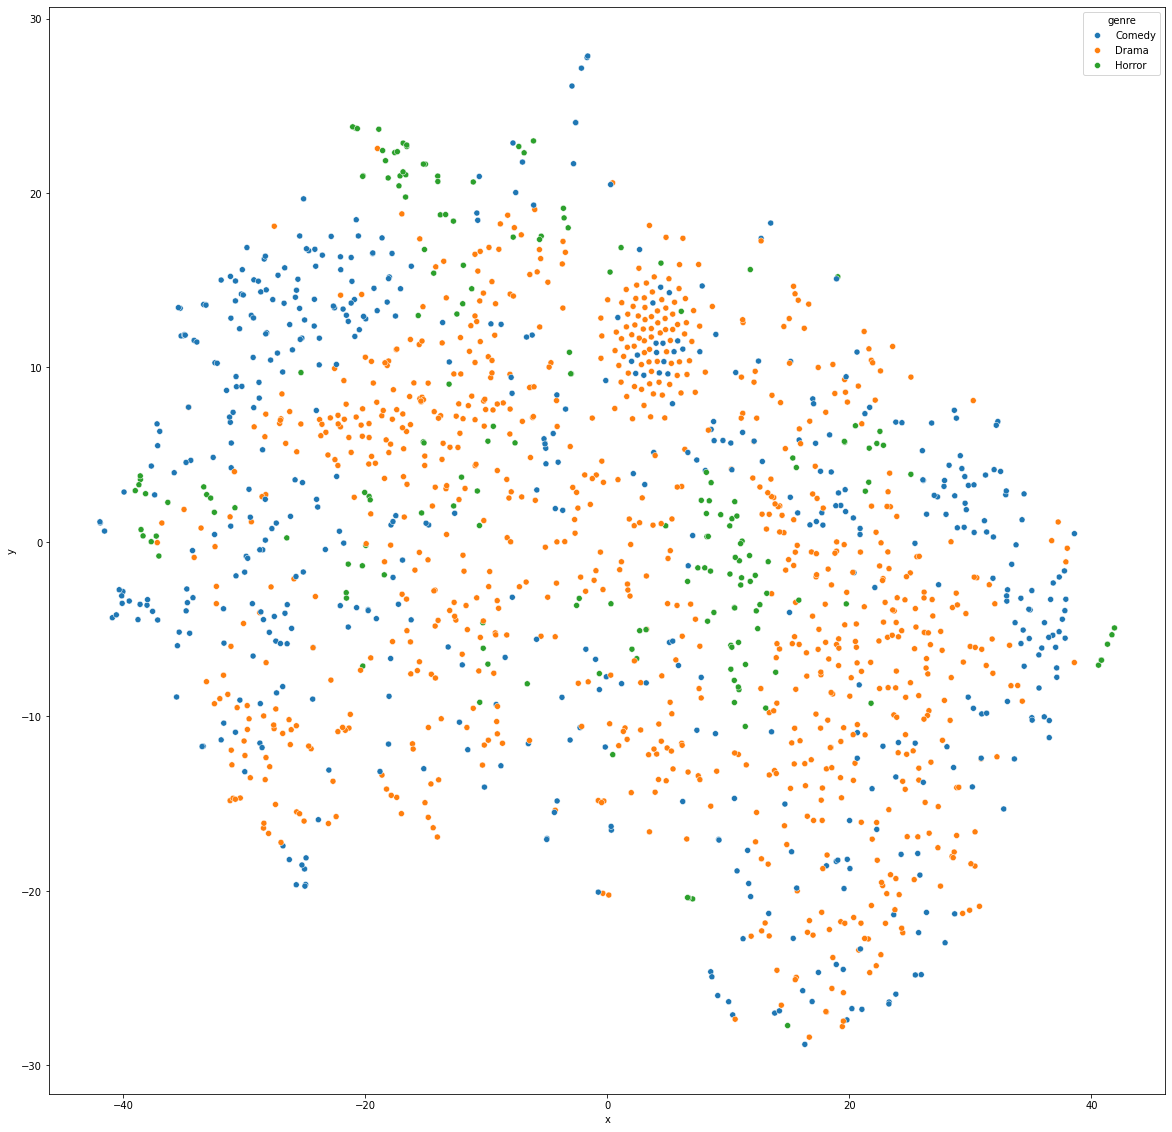

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

movie_subset_embs.shape
movie_2d = TSNE(n_components=2, init='pca').fit_transform(movie_subset_embs)
movie_df = pd.DataFrame(
    data={
        "x": movie_2d[:, 0],
        "y": movie_2d[:, 1],
        "genre": movie_genres[movie_inds_one_genre],
    }
)

plt.figure(figsize=(20, 20))
ax = sns.scatterplot(x="x", y="y", hue='genre',data=movie_df)

In [20]:
#visualize test result
pred_tmp = []
actual_tmp = []
with torch.no_grad():
    for feature, rating in validation_dataloader:
        pred = model(feature)
        pred_tmp.append(pred.cpu().numpy() + 2)
        actual_tmp.append(rating.cpu().numpy() + 2)

In [21]:
actual = actual_tmp[0][:100]
predictions = pred_tmp[0][:100]

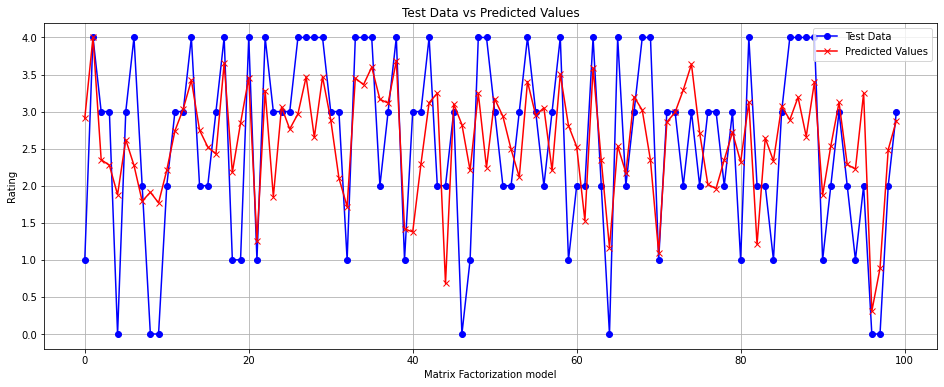

In [22]:
x_point = range(0, 100)
plt.figure(figsize=(16, 6))
# Plotting test data
plt.plot(x_point, actual, marker='o', color='blue', label='Test Data')
# Plotting predicted values
plt.plot(x_point, predictions, marker='x', color='red', label='Predicted Values')
plt.xlabel('Matrix Factorization model')
plt.ylabel('Rating')
plt.title('Test Data vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()